In [2]:
from visual_behavior import utilities as vbu
import visual_behavior.plotting as vbp
from visual_behavior.utilities import EyeTrackingData
from visual_behavior import database as db
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import seaborn as sns
import matplotlib.patches as patches

from scipy import stats

from multiprocessing import Pool

from dro.modules import eye_tracking as et
from dro.modules import plotting as plot_utils

from scipy.signal import spectrogram
import pywt

In [28]:
%matplotlib notebook
%widescreen

In [29]:
osid = 833812106
ed = et.open_eye_data(osid)
bd = et.open_behavior_data(osid)

opening eye data for osid = 833812106
opening behavior data for osid = 833812106


<IPython.core.display.Javascript object>


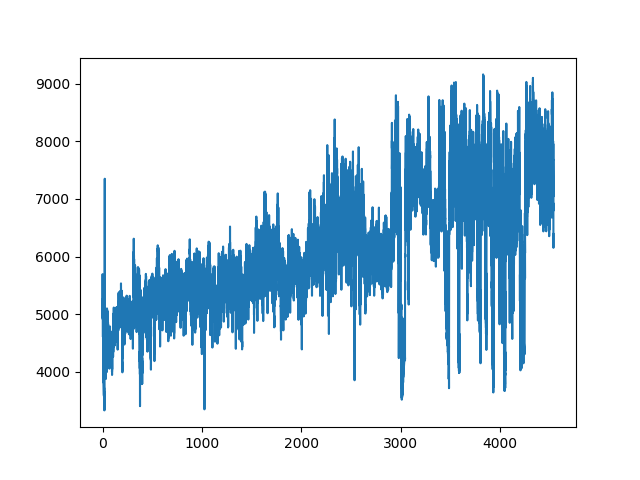

In [30]:
fig,ax=plt.subplots()
ax.plot(
    ed.ellipse_fits['pupil']['time'],
    ed.ellipse_fits['pupil']['blink_corrected_area']
)

## I'll use the same methods to apply a sliding window FFT to the pupil data

<IPython.core.display.Javascript object>


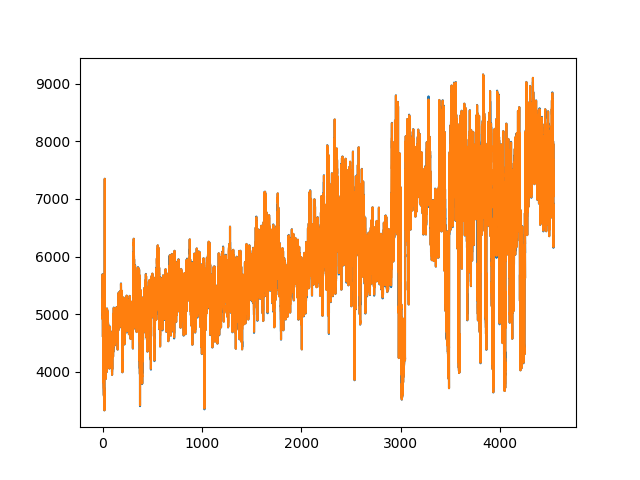

In [31]:
df = ed.ellipse_fits['pupil'].set_index('time')
t = df.index.values
y = df['blink_corrected_area'].fillna(method='ffill').values

new_t = np.arange(t.min(),t.max(),0.005)
y_interp = np.interp(new_t, t, y)

fig,ax= plt.subplots()
ax.plot(t,y)
ax.plot(new_t,y_interp)

In [32]:
delta_t = 4
Nw = np.int(2**np.round(np.log2(delta_t * f_s)))
Nw

1024

In [33]:
y_interp

array([5093.45544172, 5182.7221256 , 5271.98880947, ..., 6424.35198679,
       6413.03876244, 6401.7255381 ])

In [34]:
f_s = 200
f, t_, Sxx = spectrogram(y_interp, f_s, window='hanning', nperseg=Nw, noverlap = Nw - 100, detrend='constant', scaling='spectrum')

In [35]:
np.shape(Sxx),np.shape(t_),np.shape(new_t)

((513, 9065), (9065,), (907470,))

In [36]:
(f - delta_f/2)

array([-9.76562500e-02,  9.76562500e-02,  2.92968750e-01,  4.88281250e-01,
        6.83593750e-01,  8.78906250e-01,  1.07421875e+00,  1.26953125e+00,
        1.46484375e+00,  1.66015625e+00,  1.85546875e+00,  2.05078125e+00,
        2.24609375e+00,  2.44140625e+00,  2.63671875e+00,  2.83203125e+00,
        3.02734375e+00,  3.22265625e+00,  3.41796875e+00,  3.61328125e+00,
        3.80859375e+00,  4.00390625e+00,  4.19921875e+00,  4.39453125e+00,
        4.58984375e+00,  4.78515625e+00,  4.98046875e+00,  5.17578125e+00,
        5.37109375e+00,  5.56640625e+00,  5.76171875e+00,  5.95703125e+00,
        6.15234375e+00,  6.34765625e+00,  6.54296875e+00,  6.73828125e+00,
        6.93359375e+00,  7.12890625e+00,  7.32421875e+00,  7.51953125e+00,
        7.71484375e+00,  7.91015625e+00,  8.10546875e+00,  8.30078125e+00,
        8.49609375e+00,  8.69140625e+00,  8.88671875e+00,  9.08203125e+00,
        9.27734375e+00,  9.47265625e+00,  9.66796875e+00,  9.86328125e+00,
        1.00585938e+01,  

<IPython.core.display.Javascript object>


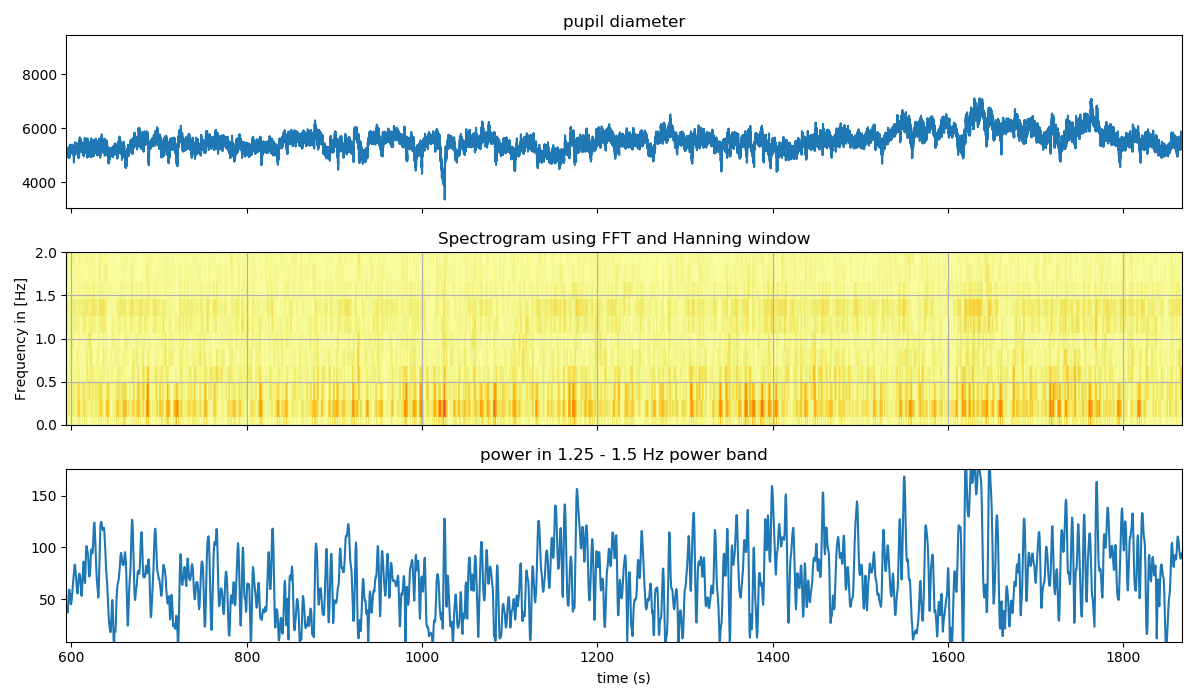

In [37]:
delta_f  =  f[1] - f[0]
delta_t_ = t_[1] - t_[0]
t2  = t_ + new_t[0] - delta_t_

fig,ax=plt.subplots(3,1,figsize=(12,7),sharex=True)
ax[0].plot(new_t,y_interp)
im = ax[1].pcolormesh(t2, f - delta_f/2, np.sqrt(2*Sxx), cmap = "inferno_r")#, alpha = 0.5)
ax[1].grid(True)
ax[1].set_ylabel("Frequency in [Hz]")
ax[1].set_ylim(0, 2)
ax[1].set_xlim(np.min(t2),np.max(t2))
ax[1].set_title("Spectrogram using FFT and Hanning window")

power_in_image_f = np.sqrt(2*Sxx)[7,:]

ax[2].plot(t_,power_in_image_f)

ax[2].set_title('power in 1.25 - 1.5 Hz power band')
ax[0].set_title('pupil diameter')

# ax[0].set_xlim(3200,3800)
ax[2].set_xlabel('time (s)')
fig.tight_layout()